<a href="https://colab.research.google.com/github/sukiboo/neural_transfer/blob/master/neural_style_transfer_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

Neural Style Transfer is a technique of utilizing a pretrained image classifier to stylize one image (content image) in an artistic fashion of another image (style image) to create a new artwork (transfer image).

In this project we will use the pre-trained VGG19 network to extract features from the images and generate art.


In [99]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import vgg19
import matplotlib.pyplot as plt
import IPython.display as display
import seaborn as sns

sns.set_theme(style='darkgrid', palette='muted', font='monospace')

# Input Images

Download content and style images from the [GitHub repository](https://github.com/sukiboo/neural_transfer), though you can use any other images.

In [100]:
# select content and style images
content_image_name = 'kitty.jpg'
style_image_name = 'monet.jpg'

# download images
repo_path = 'https://raw.githubusercontent.com/sukiboo/neural_transfer/master'
content_image_path = tf.keras.utils.get_file(origin=f'{repo_path}/content_images/{content_image_name}')#, cache_subdir='/content/')
style_image_path = tf.keras.utils.get_file(origin=f'{repo_path}/style_images/{style_image_name}')


VGG19 was trained on 224-by-244 images and hence it expects to receive an image of the shape (224, 224, 3) as an input.

While technically any image larger than 30 x 30 pixels can be propagated through the network, it's not likely that the features of excessively small or large images will be extracted successfully.
Thus we reshape our content and style images to be no larger than 512 pixels in any direction.

The following function loads and reshapes an image.

In [101]:
# load and resize an image
def load_and_resize_image(path_to_image, max_dim=512):

    # load image
    image = tf.io.decode_image(tf.io.read_file(path_to_image), dtype=tf.float32)

    # resize image if it is larger than max_dim
    image_size = tf.cast(tf.shape(image)[:-1], dtype=tf.float32)
    if max(image_size) > max_dim:
        scale = tf.cast(max_dim / max(image_size), dtype=tf.float32)
        image = tf.image.resize(image, tf.cast(image_size*scale, dtype=tf.int32))

    return image

Resize content and style images and display them.

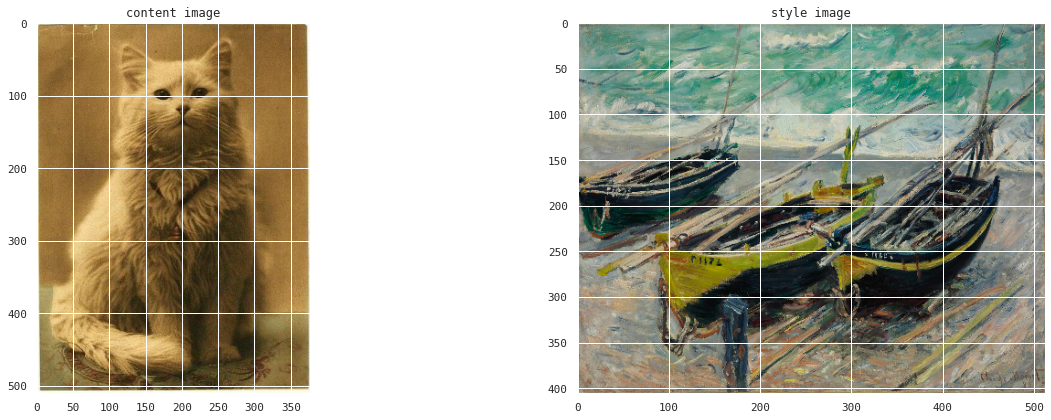

In [102]:
# load and resize content and style images
content_image = load_and_resize_image(content_image_path)
style_image = load_and_resize_image(style_image_path)

# initialize generated image as the content image
transfer_image = tf.Variable(content_image)

# display images
plt.figure(figsize=(20,6))
plt.subplot(1,2,1).axis('on')
plt.title('content image')
plt.imshow(content_image)
plt.subplot(1,2,2).axis('on')
plt.title('style image')
plt.imshow(style_image)
plt.tight_layout()
plt.show()

# Model Construction
First, we load pre-trained VGG19 without the fully-connected layers.

In [103]:
# define the feature extractor
cnn = vgg19.VGG19(include_top=False, weights='imagenet')

# display the layers
print('\ncnn layers:', *map(lambda layer: '{:2d} -- {:s}'.format(cnn.layers.index(layer), layer.name), cnn.layers), sep='\n  ')


cnn layers:
   0 -- input_6
   1 -- block1_conv1
   2 -- block1_conv2
   3 -- block1_pool
   4 -- block2_conv1
   5 -- block2_conv2
   6 -- block2_pool
   7 -- block3_conv1
   8 -- block3_conv2
   9 -- block3_conv3
  10 -- block3_conv4
  11 -- block3_pool
  12 -- block4_conv1
  13 -- block4_conv2
  14 -- block4_conv3
  15 -- block4_conv4
  16 -- block4_pool
  17 -- block5_conv1
  18 -- block5_conv2
  19 -- block5_conv3
  20 -- block5_conv4
  21 -- block5_pool


# Model Settings
Specify the content and style layersas well as the weights of individual layers.

In [104]:
# indices of content and style layers
content_layer_index = [21]
style_layer_index = [1, 2, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15]

# weights of individual layers
content_layer_weight = [1]
style_layer_weight = [3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1]

Extract the selected layers.

In [105]:
# get content and style layers
content_layers = [cnn.layers[k] for k in content_layer_index]
style_layers = [cnn.layers[k] for k in style_layer_index]

# display content and style layers
print('\nstyle layers:', *map(lambda layer: '{:3d} -- {:s}'.format(cnn.layers.index(layer), layer.name), style_layers), sep='\n  ')
print('\ncontent layers:', *map(lambda layer: '{:3d} -- {:s}'.format(cnn.layers.index(layer), layer.name), content_layers), sep='\n  ')


style layers:
    1 -- block1_conv1
    2 -- block1_conv2
    4 -- block2_conv1
    5 -- block2_conv2
    7 -- block3_conv1
    8 -- block3_conv2
    9 -- block3_conv3
   10 -- block3_conv4
   12 -- block4_conv1
   13 -- block4_conv2
   14 -- block4_conv3
   15 -- block4_conv4

content layers:
   21 -- block5_pool


Construct the model.

In [106]:
# construct the model that outputs activations of content and style layers
model = Model(inputs=[cnn.input], outputs=dict([(layer.name, layer.output) for layer in content_layers+style_layers]))

# freeze the model
model.trainable = False

# display model summary
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

The following function preprocesses an image and propagetes it throught the constructed model, thus extracting content and style features.

In [107]:
# extract features of a given image
def extract_features(image):

    # preprocess the image for the cnn
    cnn_image = vgg19.preprocess_input(tf.expand_dims(image*255, axis=0))

    # propagate image through the cnn
    outputs = model(cnn_image)

    return outputs

# Loss Functions
Next, we define loss functions which are going to be minimized during the optimization process of the transfer image.

In this notebook we minimize over three losses:
* Content loss: represents the difference between content features of the transfer and content images.
* Style loss: represents the difference between style features of the transfer and style images
* Total variation loss: penalizes high-frequency artifacts in the transfer image.

## Content Loss
We begin by definig the content loss, which we measure as 2-norm of the differences between the transfer and the content images.

In [108]:
# extract features from the content image
content_outputs = extract_features(content_image)
content_features = dict([(layer.name, content_outputs[layer.name]) for layer in content_layers])
content_scale = dict([(layer.name, tf.reduce_sum(content_features[layer.name]**2)) for layer in content_layers])

# compute content loss
def compute_content_loss(outputs):

    # compute square loss for each content layer
    content_layer_loss = [\
        tf.reduce_sum((outputs[layer.name] - content_features[layer.name])**2) / content_scale[layer.name] for layer in content_layers]

    # weight and sum content layer losses according to content layer weights
    content_loss = tf.reduce_sum(tf.multiply(content_layer_loss, content_layer_weight)) / tf.cast(tf.reduce_sum(tf.abs(content_layer_weight)), dtype=tf.float32)

    return content_loss

## Style Loss
Next, we define the style loss, which is computed as

In [109]:
# compute gram matrix of a 4-array of the shape (batch, I, J, channels)
def compute_gram_matrix(feature_array):

    gram_matrix = tf.linalg.einsum('bijc,bijd->bcd', feature_array, feature_array) / tf.cast(tf.reduce_prod(feature_array.shape[1:-1]), tf.float32)

    return gram_matrix

In [110]:
# extract the features of content and style images and compute their gram matrix
style_outputs = extract_features(style_image)
style_gram_matrix = dict([(layer.name, compute_gram_matrix(style_outputs[layer.name])) for layer in style_layers])
content_gram_matrix = dict([(layer.name, compute_gram_matrix(content_outputs[layer.name])) for layer in style_layers])
style_scale = dict([(layer.name, tf.reduce_sum(tf.abs(content_gram_matrix[layer.name] - style_gram_matrix[layer.name]))) for layer in style_layers])


# compute style loss
def compute_style_loss(outputs):

    # compute square loss for each style layer
    style_layer_loss = [\
        tf.reduce_sum(tf.abs(compute_gram_matrix(outputs[layer.name]) - style_gram_matrix[layer.name])) / style_scale[layer.name]\
        for layer in style_layers]

    # weight and sum style layer losses according to style layer weights
    style_loss =  tf.reduce_sum(tf.multiply(style_layer_loss, style_layer_weight)) / tf.cast(tf.reduce_sum(tf.abs(style_layer_weight)), dtype=tf.float32)

    return style_loss

## Variation Loss
Variation of an image represents how much pixel values fluctuate within the image: smooth fuzzy images generally have low variation, while sharp images with many edges tend to have a large one.
The contribution of the variation loss for the style transfer is two-fold:
* to penalize high-frequency artefacts (noise) in the transfer image;
* to promote preservation of the edges of the original content image.

We consider two approaches to measuring variation loss --- the sum of absolute differences (i.e. 1-norm) and the square root of the sum of squared differences (i.e. 2-norm).
We refer to those as 1-variation and 2-variation respectively.
Note that we do not measure the variation of the transfer image itself but the rather the variation of the difference between the transfer and content images, which is additionally scaled based on the variations of the original content and style images.

The reason for considering two variation losses is that they both have beneficial effect on the transfer image: 1-variation seems to enforce lines and edges thus making the image crisper, and 2-variation tends to smooth out sharp noise thus making the image cleaner.

We first compute the variation of the content and the original (i.e. before resizing) style images.

In [111]:
# compute variation of the content image
content_variation_horizontal = content_image[:,:-1,:] - content_image[:,1:,:]
content_variation_vertical = content_image[:-1,:,:] - content_image[1:,:,:]
# compute 1-variation of the content image
content_variation_l1_horizontal = tf.reduce_sum(tf.abs(content_variation_horizontal))
content_variation_l1_vertical = tf.reduce_sum(tf.abs(content_variation_vertical))
# compute 2-variation of the content image
content_variation_l2_horizontal = tf.reduce_sum(content_variation_horizontal**2)
content_variation_l2_vertical = tf.reduce_sum(content_variation_vertical**2)

# compute variation of the original style image
style_original = tf.io.decode_image(tf.io.read_file(style_image_path), dtype=tf.float32)
style_variation_horizontal = style_original[:,:-1,:] - style_original[:,1:,:]
style_variation_vertical = style_original[:-1,:,:] - style_original[1:,:,:]
# compute 1-variation of the style image
style_variation_l1_horizontal = tf.reduce_sum(tf.abs(style_variation_horizontal))
style_variation_l1_vertical = tf.reduce_sum(tf.abs(style_variation_vertical))
# compute 2-variation of the style image
style_variation_l2_horizontal = tf.reduce_sum(style_variation_horizontal**2)
style_variation_l2_vertical = tf.reduce_sum(style_variation_vertical**2)

# report computed variations
print('content l1 variation: {:.4f} / {:.4f}'.format(content_variation_l1_horizontal.numpy(), content_variation_l1_vertical.numpy()))
print('content l2 variation: {:.4f} / {:.4f}'.format(content_variation_l2_horizontal.numpy(), content_variation_l2_vertical.numpy()))
print('style l1 variation: {:.4f} / {:.4f}'.format(style_variation_l1_horizontal.numpy(), style_variation_l1_vertical.numpy()))
print('style l2 variation: {:.4f} / {:.4f}'.format(style_variation_l2_horizontal.numpy(), style_variation_l2_vertical.numpy()))

content l1 variation: 16507.9199 / 16613.3242
content l2 variation: 1051.9380 / 1250.0348
style l1 variation: 154980.5312 / 181262.5938
style l2 variation: 16020.0000 / 21112.3633


Next, define the function that computes 1-variation and 2-variation losses:

In [112]:
# compute variation loss
def compute_variation_loss(image, variation_l1_l2_weights=[0,1]):

    # compute image variation
    variation_horizontal = image[:,:-1,:] - image[:,1:,:]
    variation_vertical = image[:-1,:,:] - image[1:,:,:]

    # compute 1-norm between transfer and content images
    variation_loss_l1_horizontal = tf.reduce_sum(tf.abs(variation_horizontal - content_variation_horizontal)) * tf.reduce_sum(tf.abs(variation_horizontal))
    variation_loss_l1_vertical = tf.reduce_sum(tf.abs(variation_vertical - content_variation_vertical)) * tf.reduce_sum(tf.abs(variation_vertical))
    # scale 1-variation loss
    variation_loss_l1_horizontal *= style_variation_l1_horizontal / (content_variation_l1_horizontal + 1e-32)
    variation_loss_l1_vertical *= style_variation_l1_vertical / (content_variation_l1_vertical + 1e-32)
    variation_loss_l1 = variation_loss_l1_horizontal + variation_loss_l1_vertical

    # compute 2-norm between transfer and content images
    variation_loss_l2_horizontal = tf.reduce_sum((variation_horizontal - content_variation_horizontal)**2) * tf.reduce_sum(variation_horizontal**2)
    variation_loss_l2_vertical = tf.reduce_sum((variation_vertical - content_variation_vertical)**2) * tf.reduce_sum(variation_vertical**2)
    # scale 2-variation loss
    variation_loss_l2_horizontal *= style_variation_l2_horizontal / (content_variation_l2_horizontal + 1e-32)
    variation_loss_l2_vertical *= style_variation_l2_vertical / (content_variation_l2_vertical + 1e-32)
    variation_loss_l2 = tf.sqrt(1e-32 + variation_loss_l2_horizontal + variation_loss_l2_vertical)

    # weight and sum 1- and 2-variation losses
    variation_loss = tf.reduce_sum(tf.multiply([variation_loss_l1, variation_loss_l2], variation_l1_l2_weights))\
                    / tf.cast(tf.reduce_sum(tf.abs(variation_l1_l2_weights)), dtype=tf.float32)

    return variation_loss

# Optimization Settings
Specify the optimizer, loss functional weights, and hyperparameters.

In [113]:
# neural transfer parameters
content_weight = 1
style_weight = 10
variation_weight = 1e-05

# optimization parameters
iterations = 100
learning_rate = 1e-01
decay_rate = 5e-02

# define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, decay=decay_rate)

Define the function that optimizes the transfer image.

In [114]:
# perform a step of optimization algorithm
def optimize_image(image):

    with tf.GradientTape() as tape:
        # propagate image through the network
        outputs = extract_features(image)

        # compute losses
        content_loss = content_weight * compute_content_loss(outputs)
        style_loss = style_weight * compute_style_loss(outputs)

        # optionally compute variation loss
        if variation_weight > 0:
            variation_loss = variation_weight * compute_variation_loss(image)
        else:
            variation_loss = .0

        # total loss
        total_loss = content_loss + style_loss + variation_loss

    # compute gradients
    gradients = tape.gradient(total_loss, image)
    # optimize an image
    optimizer.apply_gradients([(gradients, image)])
    image.assign(tf.clip_by_value(image, 0, 1))

    return content_loss, style_loss, variation_loss

Define the function that displays the transfer image and current losses.

In [115]:
# show transfer image and report losses
def show_progress(iteration=0, content_losses=[], style_losses=[], variation_losses=[]):

    # show image
    plt.figure(figsize=(18,9))
    plt.subplot(1,2,1).axis('off')
    plt.imshow(transfer_image.read_value())

    # show losses
    plt.subplot(1,2,2)
    if iteration > 0:
        plt.plot(range(iteration), style_losses, color='#ff4422', linewidth=2, label='style loss')
        plt.plot(range(iteration), content_losses, color='#4488ff', linewidth=2, label='content loss')
        plt.plot(range(iteration), variation_losses, color='#51cc8e', linewidth=2, label='variation loss')
        plt.legend()
        plt.ylim(0, 2*max(content_losses[-1], style_losses[-1], variation_losses[-1]).numpy())
        #plt.yscale('symlog')

    # clear the output
    display.clear_output(wait=True)

    # print losses
    if content_losses and style_losses and variation_losses:
        print('  {:d} / {:d} -- content / style / variation loss: {:.2e} / {:.2e} / {:.2e}'\
                .format(iteration, iterations, content_losses[-1], style_losses[-1], variation_losses[-1]))

    # display plot
    plt.tight_layout()
    plt.show()

    return

# Transfer Image Generation
Run the optimization process to generate the transfer image.

  100 / 100 -- content / style / variation loss: 1.47e-01 / 5.17e-01 / 1.52e-01


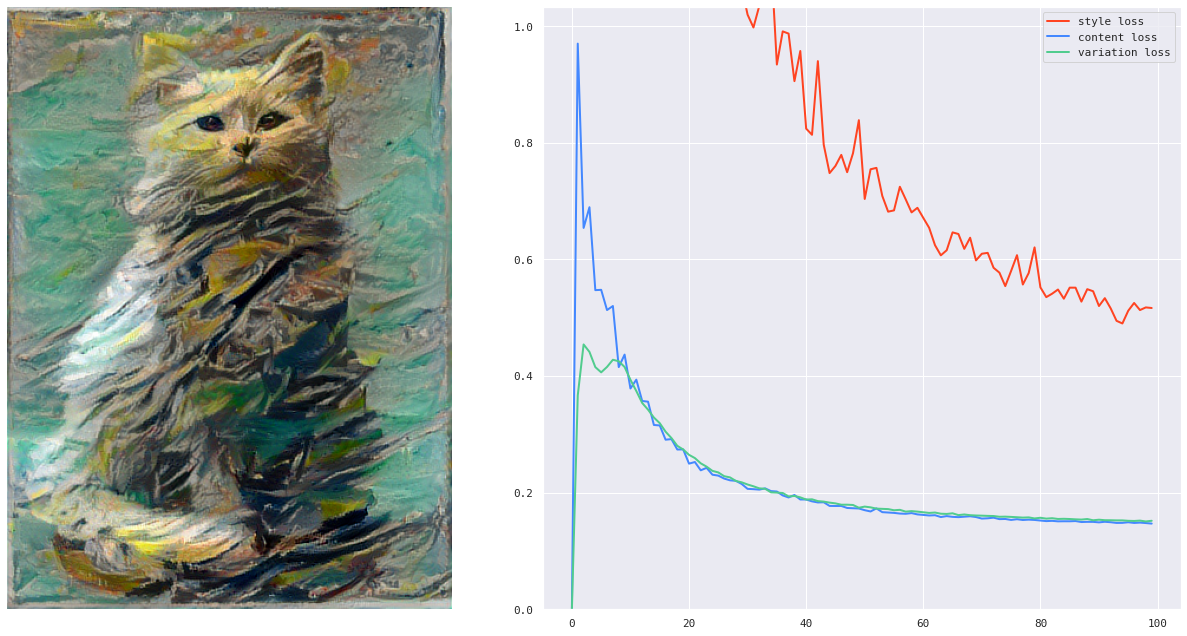

In [116]:
# iteratively update the image
show_progress()
content_losses, style_losses, variation_losses = [], [], []
for i in range(iterations):

    # perform a step of neural transfer
    print('.', end='')
    content_loss, style_loss, variation_loss = optimize_image(transfer_image)
    content_losses.append(content_loss)
    style_losses.append(style_loss)
    variation_losses.append(variation_loss)

    # update output
    if (i + 1) % 10 == 0:
        show_progress(i+1, content_losses, style_losses, variation_losses)

Display content, transfer, and style images.

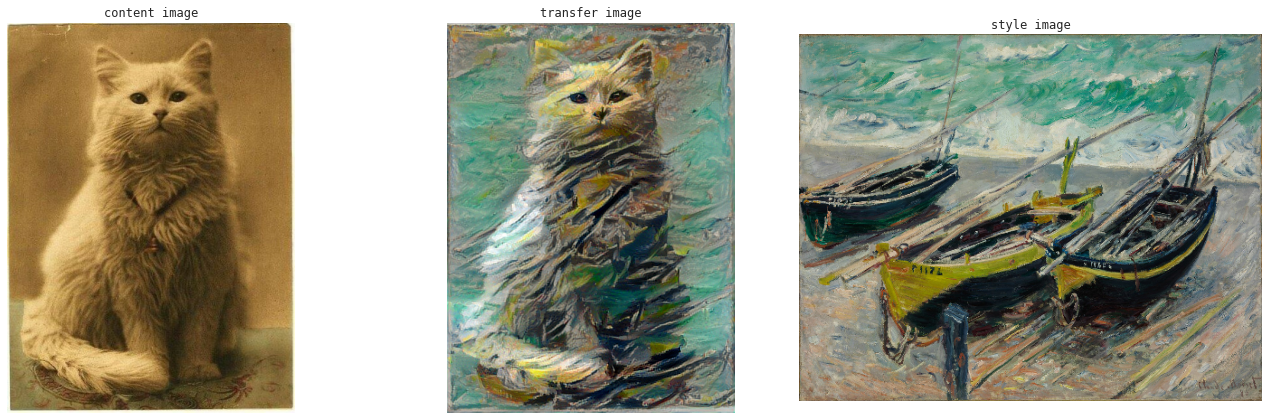

In [117]:
# display images
plt.figure(figsize=(19,6))
plt.subplot(1,3,1).axis('off')
plt.title('content image')
plt.imshow(content_image)
plt.subplot(1,3,2).axis('off')
plt.title('transfer image')
plt.imshow(transfer_image.read_value())
plt.subplot(1,3,3).axis('off')
plt.title('style image')
plt.imshow(style_image)
plt.tight_layout()
plt.show()

# Result

And here's the final image!

You can play around with other content and style images or tweak the optimization parameters for different results.

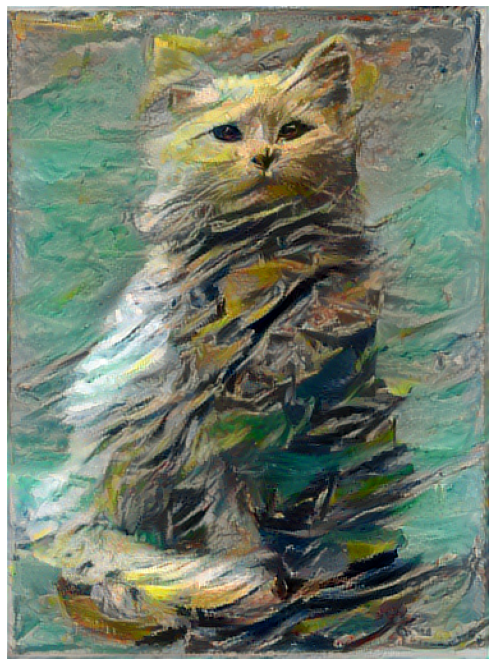

In [118]:
plt.figure(figsize=(12,12))
plt.imshow(transfer_image.read_value())
plt.grid(None)
plt.axis('off')
plt.show()